In [1]:
import numpy as np
import numba
import copy
import matplotlib.pyplot as plt
import scipy

np.random.seed(1)

In [2]:
def sampleSpinHeatbath(lat, i, j, betaj, rcheck):
    """sample spin for site (i, j) using heat-bath algorithm

    Parameters
    ----------
    lat : np.array, shape (nx, ny)
        2D lattice of +1 and -1
    i : int
        site index along x
    j : int
        site index along y
    betaj : float
        inverse temperature in reduced units
    rcheck : float
        uniform random number for proposed move

    Returns
    -------
    int
        sampled spin
    int
        change to total magnetization
    """

    lattice = copy.deepcopy(lat)
    s0 = lattice[i, j]
    lattice[i, j] = 1
    Pup = np.exp(-betaj * energySite(i, j, lattice))
    lattice[i, j] = -1
    Pdown = np.exp(-betaj * energySite(i, j, lattice))
    T = Pup / (Pup + Pdown)
    if rcheck < T:
        s = 1
    else:
        s = -1
    dmtot = -(s0 - s)
    return s, dmtot


def initLattice(N):
    """Initialize lattice.

    Parameters
    ----------
    N : int
        number of sites along each dimension

    Returns
    -------
    np.array
        2D lattice of +1
    """
    lattice = np.random.choice([-1, 1], size=(N, N)).astype(np.int8)
    # lattice = np.ones((N, N))
    return lattice


def simulateHeatbath(lattice, beta, nsweeps):
    """Simulate Ising model using heat-bath algorithm.

    Parameters
    ----------
    lattice : np.array, shape (nx, ny)
        2D lattice of +1 and -1
    beta : float
        inverse temperature
    nsweeps : int
        number of sweeps

    Returns
    -------
    np.array
        array of magnetizations
    """
    lattice = copy.deepcopy(lattice)
    N = lattice.shape[0]
    Lattices = np.zeros((nsweeps, N, N))
    for sweep in range(nsweeps):
        for i in range(N):
            for j in range(N):
                rcheck = np.random.rand()
                s, dmtot = sampleSpinHeatbath(lattice, i, j, beta, rcheck)
                lattice[i, j] = s

        Lattices[sweep] = lattice

    return Lattices


def cluster(beta, lattice, N):
    """
    Cluster algorithm for Ising model

    Parameters
    ----------
    beta : float
        inverse temperature
    lattice : np.array, shape (nx, ny)
        2D lattice of +1 and -1
    N : int
        number of sites along each dimension

    Returns
    -------
    np.array
        array of sites in cluster
    """

    lattice = copy.deepcopy(lattice)
    pos = np.random.randint(0, N, 2)
    s = lattice[pos[0], pos[1]]
    allpos = np.where(lattice == s)
    allpos = np.vstack([allpos[0], allpos[1]]).T
    cluster = []
    passed = []
    cluster.append(pos)
    neighbors = []
    neighbors.extend(neighborList(pos[0], pos[1], N))

    while len(neighbors) > 0:
        i = neighbors[0]

        if (np.isin(i, allpos).all()) and (np.isin(i, passed).all()):
            if (1 - np.exp(-2 * beta)) > np.random.random():
                cluster.append(i)
                neighbors.extend(neighborList(i[0], i[1], N))

            passed.append(i)
        del neighbors[0]
    cluster = np.vstack(cluster)
    return cluster


def simulateCluster(lattice, beta, nsweeps):
    """Simulate Ising model using cluster algorithm.

    Parameters
    ----------
    lattice : np.array, shape (nx, ny)
        2D lattice of +1 and -1
    beta : float
        inverse temperature
    nsweeps : int
        number of sweeps

    Returns
    -------
    np.array
        array of magnetizations
    """

    lattice = copy.deepcopy(lattice)
    N = lattice.shape[0]
    Latices = np.zeros((nsweeps, N, N))

    for sweep in range(nsweeps):
        c = cluster(beta, lattice, N)
        lattice[c] *= -1

        Latices[sweep] = lattice

    return Latices


@numba.njit(nogil=True, fastmath=True)
def totalMagnetization(lattice):
    """Total magnetization of lattice.

    Parameters
    ----------
    lattice : np.array, shape (nx, nx)
        2D lattice of +1 and -1

    Returns
    -------
    int
        total magnetization
    """
    mtot = 0
    if lattice.ndim == 2:
        mtot = np.sum(lattice.flatten())

    elif lattice.ndim == 3:
        mtot = np.sum(lattice, axis=(1, 2))

    return mtot


def varMagnetization(lattice):
    """Variance of magnetization of lattice.

    Parameters
    ----------
    lattice : np.array, shape (nx, ny)
        2D lattice of +1 and -1

    Returns
    -------
    float
        variance of magnetization
    """
    varMag = np.var(lattice.flatten(), ddof=1)
    return varMag


@numba.njit(nogil=True, fastmath=True)
def unique(array):
    b = np.sort(array.ravel())
    unique = list(b[:1])
    counts = [1 for _ in unique]
    for x in b[1:]:
        if x != unique[-1]:
            unique.append(x)
            counts.append(1)
        else:
            counts[-1] += 1
    return np.array(unique), np.array(counts)


@numba.njit(nogil=True, fastmath=True)
def energySite(i, j, lattice):
    Eij = 0
    N = lattice.shape[0]

    if i > 0:  # has left neighbor
        Eij += -lattice[i, j] * lattice[i - 1, j]
    if i < N - 1:  # has right neighbor
        Eij += -lattice[i, j] * lattice[i + 1, j]
    if j > 0:  # has top neighbor
        Eij += -lattice[i, j] * lattice[i, j - 1]
    if j < N - 1:  # has bottom neighbor
        Eij += -lattice[i, j] * lattice[i, j + 1]

    return Eij


@numba.njit(nogil=True, fastmath=True)
def spinFlip(lattice, i, j, beta):
    """Calculate spin flip probability and change to total magnetization.

    Parameters
    ----------
    lattice : np.array, shape (nx, ny)
        2D lattice of +1 and -1
    i : int
        site index along x
    j : int
        site index along y
    beta : float
        inverse temperature

    Returns
    -------
    float
        acceptance ratio
    int
        change to total magnetization due to the spin flip
    """

    dE = -2 * energySite(i, j, lattice)
    A = np.exp(-beta * dE)
    dM = -2 * lattice[i, j]
    return A, dM, dE


@numba.njit(nogil=True)
def simulateMetropolis(lattice, beta, nsweeps):
    """Simulate Ising model using Metropolis algorithm.

    Parameters
    ----------
    lattice : np.array, shape (nx, ny)
        2D lattice of +1 and -1
    beta : float
        inverse temperature
    nsweeps : int
        number of sweeps

    Returns
    -------
    np.array
        array of magnetizations
    """
    lattice = lattice.copy()
    N = lattice.shape[0]
    lattices = np.zeros((nsweeps + 1, N, N))
    energies = np.zeros(nsweeps + 1)
    mags = np.zeros(nsweeps + 1)
    lattices[0] = lattice
    energies[0] = totalEnergy(lattice)
    mags[0] = totalMagnetization(lattice)
    rchecks = np.random.rand(nsweeps * N**2)
    loop_idx = 0
    for sweep in range(nsweeps):
        dE_sweep = 0
        dM_sweep = 0
        for i in range(N):
            for j in range(N):
                A, dM, dE = spinFlip(lattice, i, j, beta)
                rcheck = rchecks[loop_idx]
                if rcheck <= A or dE < 0:
                    lattice[i, j] *= -1
                    dE_sweep += dE
                    dM_sweep += dM

                loop_idx += 1

        lattices[sweep + 1] = lattice
        energies[sweep + 1] = energies[sweep] + dE_sweep
        mags[sweep + 1] = mags[sweep] + dM_sweep

    return lattices, energies, mags


@numba.njit(nogil=True, fastmath=True)
def totalEnergy(lattice):
    N = lattice.shape[0]
    energy = 0
    for i in range(N):
        for j in range(N):
            energy += energySite(i, j, lattice)

    return energy / 2


def getConfigs(N):
    """
    Generate all possible configurations of an NxN Ising model

    Parameters
    ----------
    N : int
        number of sites along each dimension

    Returns
    -------
    np.array
        array of all possible configurations
    """

    n = N**2
    configs = np.zeros((2**n, n))
    for i in range(2**n):
        bin = np.binary_repr(i, width=n)
        config = np.array([int(x) for x in bin])
        configs[i] = config
    configs[configs == 0] = -1
    return configs.reshape(-1, N, N).astype(int)


@numba.njit
def getEnergies(lattices):
    N = lattices.shape[0]
    energies = np.zeros(N, dtype=np.int64)

    for i in range(N):
        lattice = lattices[i]
        energies[i] = totalEnergy(lattice)

    return energies


@numba.njit(nogil=True, fastmath=True)
def getEdges(energies):
    uniqueEnergies = np.unique(energies)
    edges = []
    for E in uniqueEnergies:
        edges.append(E - 1)
        edges.append(E + 1)
    edges = np.array(edges)
    return np.unique(edges)


def theoreticalEnergyDistribution(beta, N):
    configs = getConfigs(N)
    energies = getEnergies(configs)
    uniqueEnergies, counts = np.unique(energies, return_counts=True)
    boltzmannFactors = np.exp(-beta * uniqueEnergies) * counts
    Z = np.sum(boltzmannFactors)
    P = boltzmannFactors / Z
    return uniqueEnergies, P


def plotTheoreticalEnergyDistribution(beta, N, ax=None, **kwargs):
    uniqueEnergies, P = theoreticalEnergyDistribution(beta, N)
    xticks = np.array([energy for energy in uniqueEnergies[::2]])

    if ax is not None:
        ax.plot(uniqueEnergies, P, marker="o", linestyle=(10, (5, 10)), zorder=10)
        ax.set_xticks(ticks=uniqueEnergies)
        ax.set_xlabel("Energy")
        ax.set_ylabel("Probability")
        ax.set_xticks(ticks=xticks, labels=xticks, **kwargs)

        return ax

    fig, ax = plt.subplots()
    ax.plot(uniqueEnergies, P, marker="o", linestyle="dashed", zorder=10)
    ax.set_xlabel("Energy")
    ax.set_ylabel("Probability")
    ax.set_xticks(ticks=xticks, labels=xticks, **kwargs)

    return ax


@numba.njit(nogil=True, fastmath=True)
def distribution(arr):
    unique_vals, counts = unique(arr)
    P = counts / np.sum(counts)
    argsort = np.argsort(unique_vals)
    return unique_vals[argsort], P[argsort]


def plotEnergyDistribution(energies, ax=None, **kwargs):
    uniqueEnergies, P = distribution(energies)
    if uniqueEnergies.shape[0] < 15:
        xticks = np.array([energy for energy in uniqueEnergies[::2]])
        marker = "o"
    else:
        xticks = np.linspace(energies.min(), energies.max(), 5)
        marker = ""

    if ax is not None:
        ax.plot(uniqueEnergies, P, marker=marker)
        ax.set_xlabel("Energy")
        ax.set_ylabel("Probability")
        ax.set_xticks(ticks=xticks, labels=xticks, **kwargs)

        return ax

    fig, ax = plt.subplots()
    ax.plot(uniqueEnergies, P, marker=marker)
    ax.set_xlabel("Energy")
    ax.set_ylabel("Probability")
    ax.set_xticks(ticks=xticks, labels=xticks, **kwargs)

    return ax


def energyHistogram(energies, ax=None, **kwargs):
    uniqueEnergies = np.unique(energies)
    edges = getEdges(energies)
    counts, bins = np.histogram(energies, bins=edges)
    if uniqueEnergies.shape[0] < 30:
        xticks = np.array([energy for energy in uniqueEnergies[::2]])
    else:
        xticks = None

    if ax is not None:
        ax.hist(energies, bins=edges, edgecolor="black")
        ax.set_xlabel("Energy")
        ax.set_ylabel("Count")

        if xticks is not None:
            ax.set_xticks(ticks=xticks, labels=xticks, **kwargs)

        return ax

    fig, ax = plt.subplots()
    ax.hist(energies, bins=edges, edgecolor="black")
    ax.set_xlabel("Energy")
    ax.set_ylabel("Count")

    if xticks is not None:
        ax.set_xticks(ticks=xticks, labels=xticks, **kwargs)

    return ax


@numba.njit(nogil=True, fastmath=True)
def c(i, x, mean, var):
    N = len(x)
    if var == 0:  # if the variance is 0 return an effectively infinity corr
        return 1e100
    #    print len(x([0:N-1])),len(x([i:N]))
    corr = 1.0 / var * 1.0 / (N - i) * np.sum((x[0 : N - i] - mean) * (x[i:N] - mean))
    return corr


@numba.njit(nogil=True, fastmath=True)
def Stats(x):
    N = len(x)
    mean = np.sum(x) / (N + 0.0)
    xSquared = x * x
    var = np.sum(xSquared) / (N + 0.0) - mean * mean
    i = 0
    tempC = 0.5
    kappa = 0.0
    while tempC > 0 and i < (N - 1):
        kappa = kappa + 2.0 * tempC
        i = i + 1
        tempC = c(i, x, mean, var)
    if kappa == 0.0:
        kappa = 1.0
    Neff = (N + 0.0) / (kappa + 0.0)
    error = np.sqrt(var / Neff)
    return (mean, var, error, kappa, i)


@numba.njit(nogil=True, fastmath=True)
def magExpectation(N, mags):
    mags = mags.copy()
    mags /= N**2  # magnetization per spin
    mean, var, error, kappa, tcutoff = Stats(mags)
    mags = mags[tcutoff:]
    unique_mags, p_mags = distribution(mags**2)
    expected_mag = np.sum(unique_mags * p_mags)

    return expected_mag, error, tcutoff, unique_mags, p_mags


@numba.njit(nogil=True, fastmath=True)
def energyExpectation(energies):
    energies = energies.copy()
    mean, var, error, kappa, tcutoff = Stats(energies)
    energies = energies[tcutoff:]
    unique_energies, p_energies = distribution(energies)
    expected_energy = np.sum(unique_energies * p_energies)

    return expected_energy, error, tcutoff, unique_energies, p_energies

In [19]:
totalEnergy(np.ones((3, 3)))

-12.0

In [18]:
getConfigs(3).shape

(512, 3, 3)

## Energy Trace

In [3]:
N = 3
beta = 0.3
nsweeps = 100000
lattice = initLattice(N)
lattices, energies, mags = simulateMetropolis(lattice, beta, nsweeps)

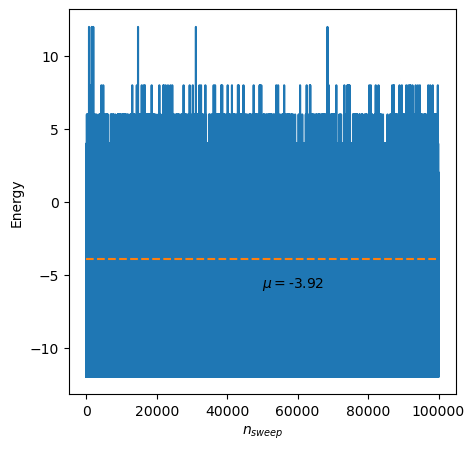

In [4]:
fig, ax = plt.subplots(figsize=(5, 5))
ax.plot(energies)
ax.set_xlabel(r"$n_{sweep}$")
ax.set_ylabel("Energy")
ax.hlines(energies.mean(), 0, nsweeps, linestyle="dashed", color="tab:orange")
ax.annotate(
    r"$\mu =$" + str(energies.mean().round(2)),
    xy=(nsweeps // 2, 1.5 * energies.mean()),
)
plt.show()

## Theoretical Vs Empritcal 9 spin energy distribution

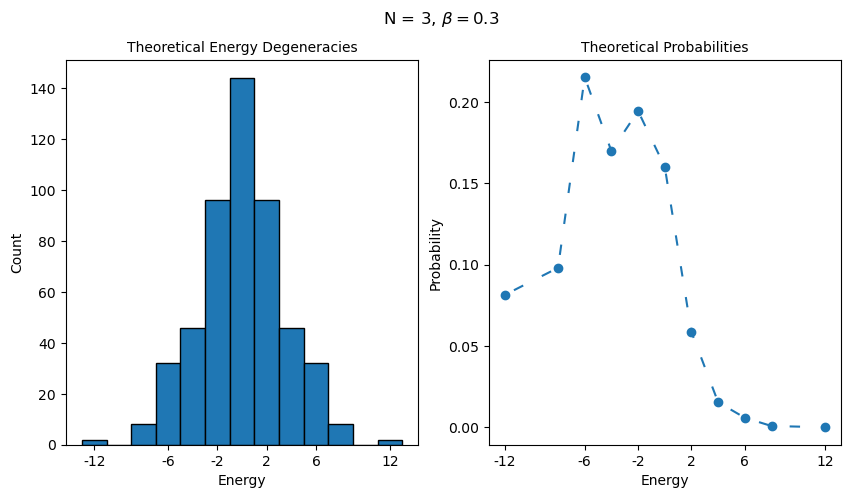

In [5]:
configs = getConfigs(N)
theoreticalEnergies = getEnergies(configs)
fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(10, 5))
energyHistogram(theoreticalEnergies, axs[0], fontsize=10)
plotTheoreticalEnergyDistribution(beta, N, axs[1], fontsize=10)
axs[0].set_title(f"Theoretical Energy Degeneracies", fontsize=10)
axs[1].set_title(f"Theoretical Probabilities", fontsize=10)
fig.suptitle(
    f"N = {N}, " + r"$\beta =$" + f"{beta:.1}",
    fontsize=12,
)
plt.show()

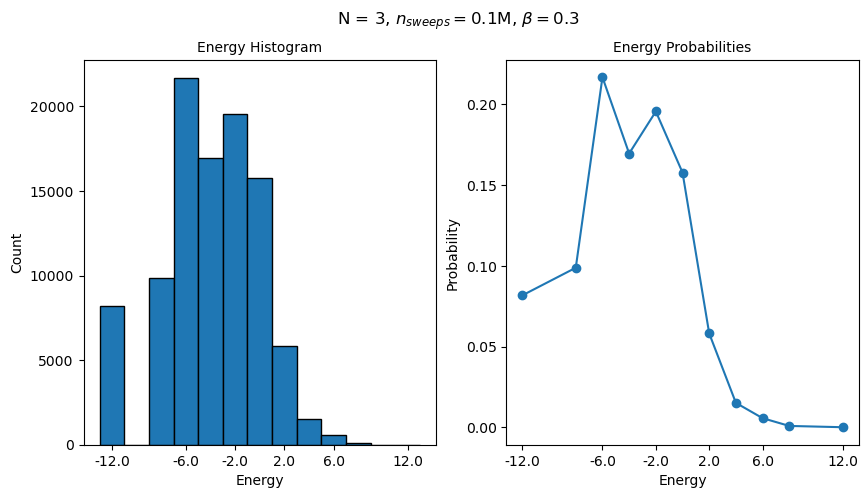

In [6]:
fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(10, 5))
energyHistogram(energies, axs[0], fontsize=10)
plotEnergyDistribution(energies, axs[1], fontsize=10)
axs[0].set_title(
    f"Energy Histogram",
    fontsize=10,
)
axs[1].set_title(
    f"Energy Probabilities",
    fontsize=10,
)
fig.suptitle(
    f"N = {N}, "
    + r"$n_{sweeps} =$"
    + f"{nsweeps / int(1e6)}M, "
    + r"$\beta =$"
    + f"{beta:.1}",
    fontsize=12,
)
plt.show()

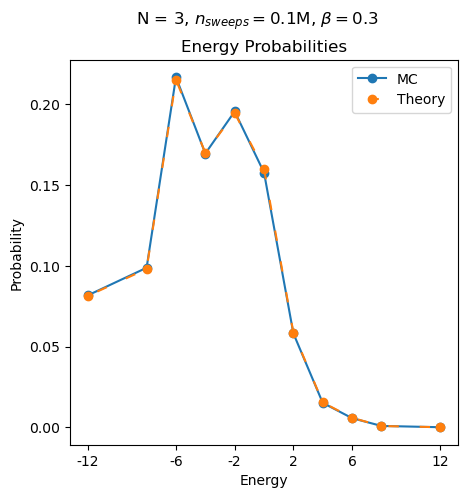

In [7]:
fig, axs = plt.subplots(figsize=(5, 5))
plotEnergyDistribution(energies, axs)
plotTheoreticalEnergyDistribution(beta, N, axs)
configs = getConfigs(N)
energies_theorey = getEnergies(configs)
unique_energies_theory, counts_theory = np.unique(energies_theorey, return_counts=True)

axs.set(xlabel="Energy")
axs.set_ylabel("Probability")
axs.set_title("Energy Probabilities")
axs.legend(["MC", "Theory"])
fig.suptitle(
    f"N = {N}, "
    + r"$n_{sweeps} =$"
    + f"{nsweeps / int(1e6)}M, "
    + r"$\beta =$"
    + f"{beta:.1}",
    fontsize=12,
)
plt.show()

## Measuring 81 spins

In [8]:
N = 27
betas = np.linspace(0, 1, 11)
betas = np.append(betas, 1e5)
nbetas = betas.shape[0]
nsweeps = 200000
lattice = initLattice(N)
nsims = nbetas
lattices_beta = np.empty((nsims, nsweeps + 1, N, N))
energies_beta = np.empty((nsims, nsweeps + 1))
mags_beta = np.empty((nsims, nsweeps + 1))

In [9]:
try:

    lattices_beta = np.load("lattices_beta.npy")
    energies_beta = np.load("energies_beta.npy")
    mags_beta = np.load("mags_beta.npy")

except:
    print("failed load")
    for i in range(nbetas):
        lattices_beta[i], energies_beta[i], mags_beta[i] = simulateMetropolis(
            lattice, betas[i], nsweeps
        )

    np.save("lattices_beta.npy", lattices_beta)
    np.save("energies_beta.npy", energies_beta)
    np.save("mags_beta.npy", mags_beta)

failed load


In [10]:
betas = np.round(betas, 2)
expected_mags = np.zeros_like(betas)
error_mags = np.zeros_like(betas)
tcutoff_mags = np.zeros_like(betas, dtype=object)
unique_mags = np.zeros_like(betas, dtype=object)
prob_mags = np.zeros_like(betas, dtype=object)

expected_energies = np.zeros_like(betas)
error_energies = np.zeros_like(betas)
tcutoff_energies = np.zeros_like(betas, dtype=object)
unique_energies = np.zeros_like(betas, dtype=object)
prob_energies = np.zeros_like(betas, dtype=object)

for i in range(nbetas):
    beta = betas[i]

    exp, err, tcut, unique, p = magExpectation(N, mags_beta[i])
    expected_mags[i] = np.round(exp, 12)
    error_mags[i] = np.round(err, 12)
    tcutoff_mags[i] = np.round(tcut, 12)
    unique_mags[i] = np.round(unique, 12)
    prob_mags[i] = np.round(p, 12)

    exp, err, tcut, unique, p = energyExpectation(energies_beta[i])
    expected_energies[i] = np.round(exp, 12)
    error_energies[i] = np.round(err, 12)
    tcutoff_energies[i] = np.round(tcut, 12)
    unique_energies[i] = np.round(unique, 12)
    prob_energies[i] = np.round(p, 12)

beta_labels = betas.astype(str)
beta_labels[-1] = r"$\infty$"
loose_dash = (10, (5, 10))

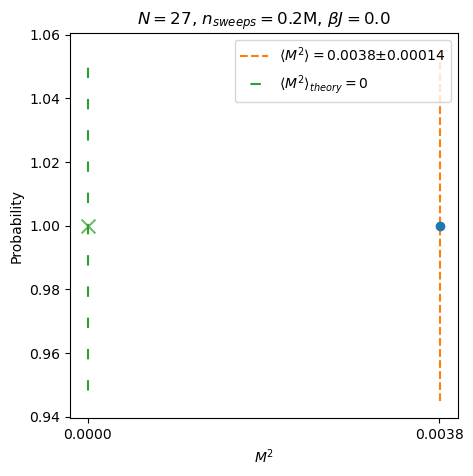

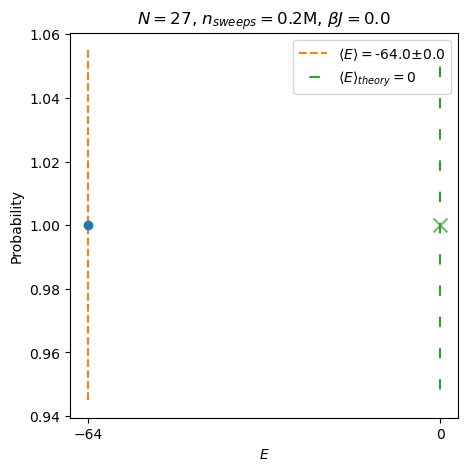

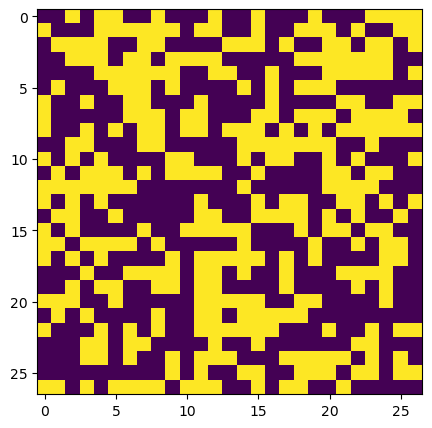

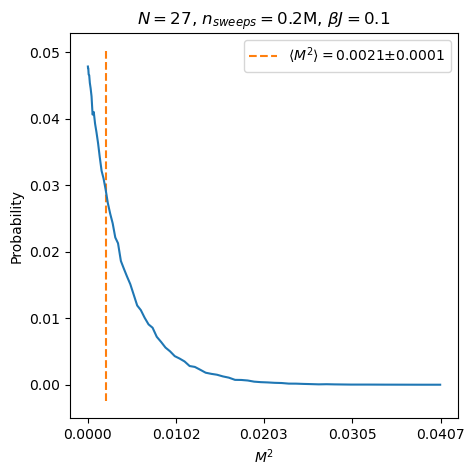

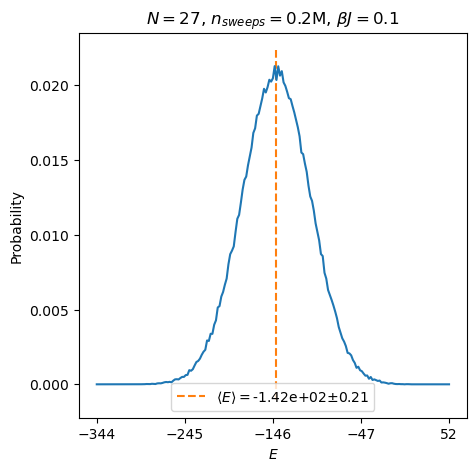

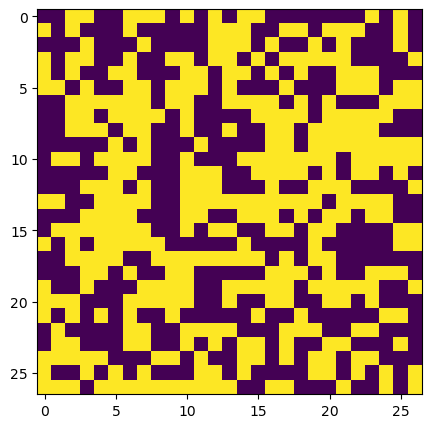

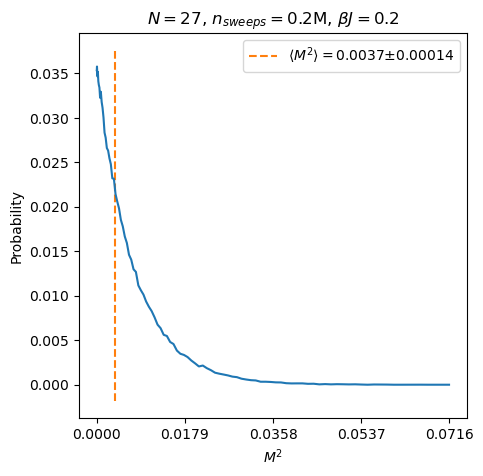

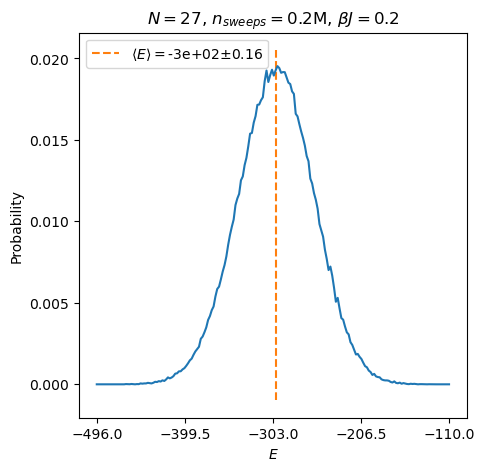

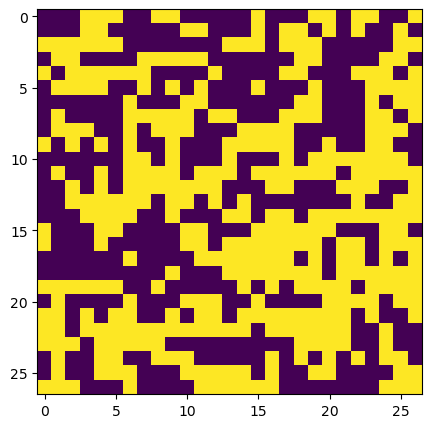

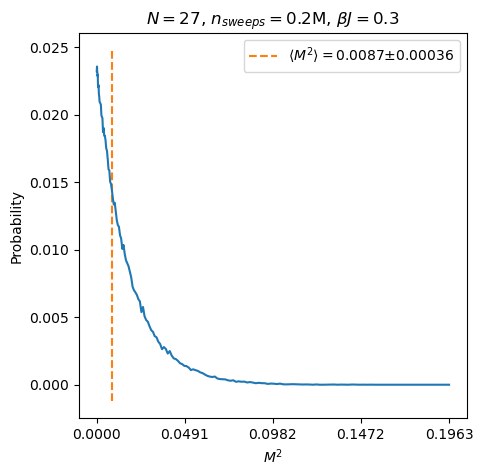

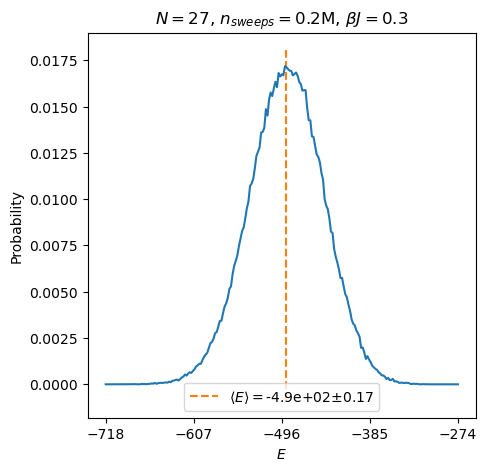

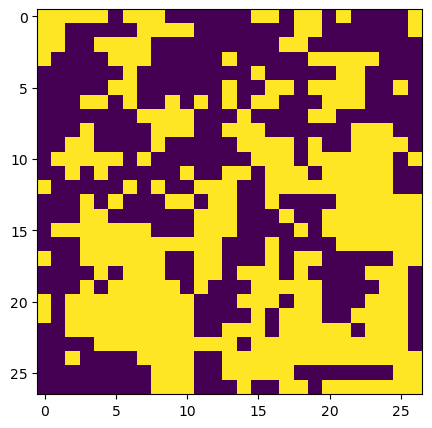

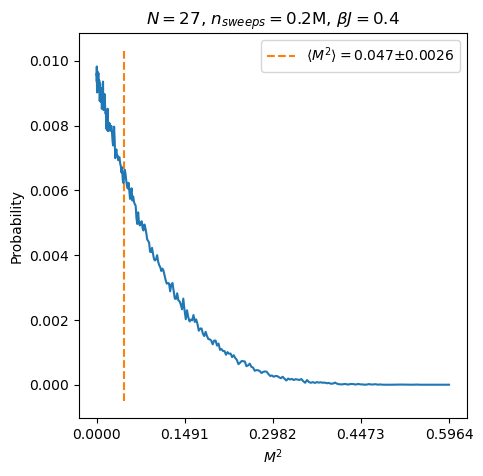

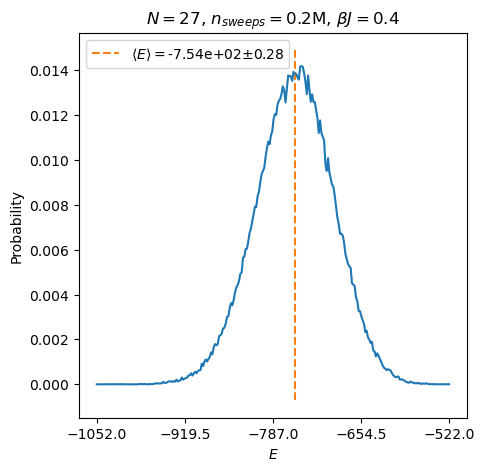

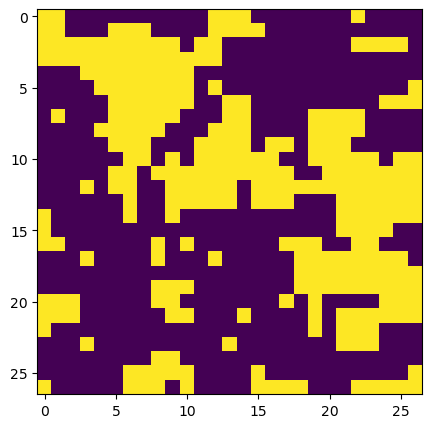

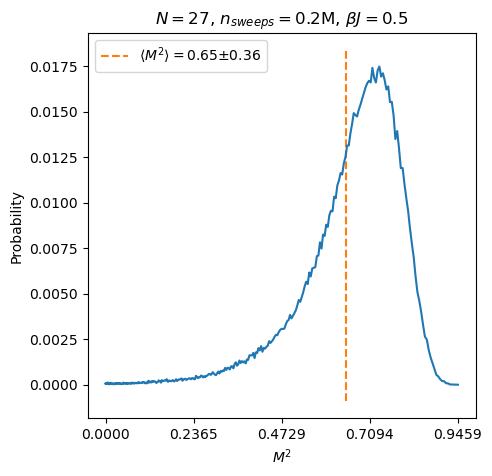

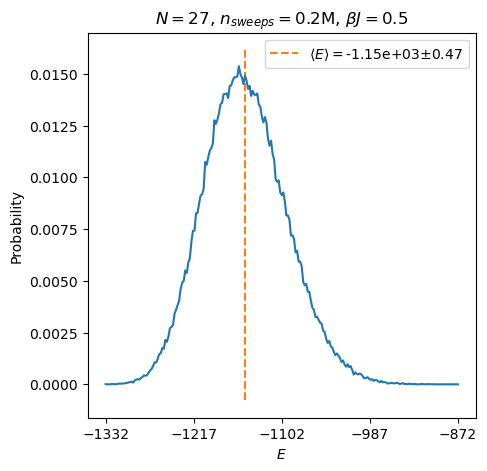

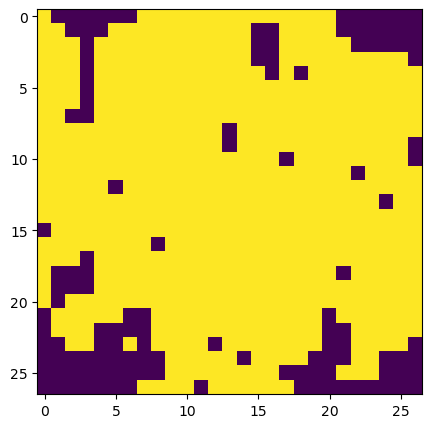

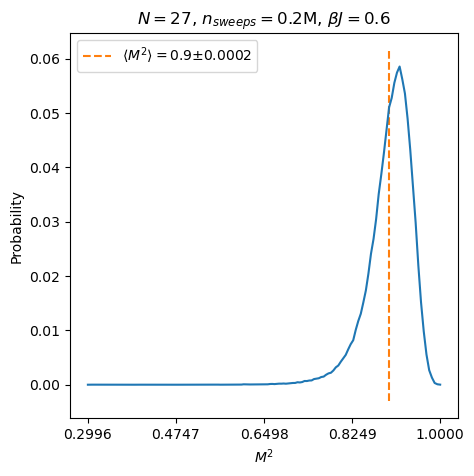

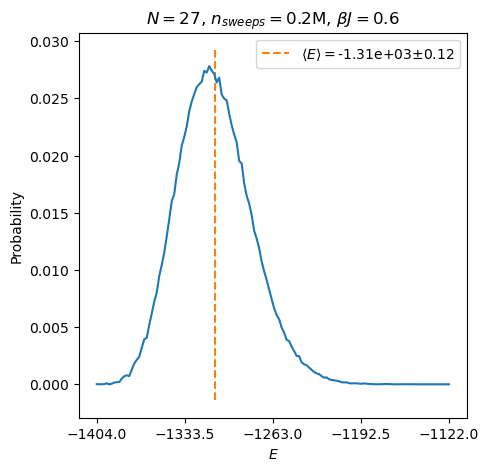

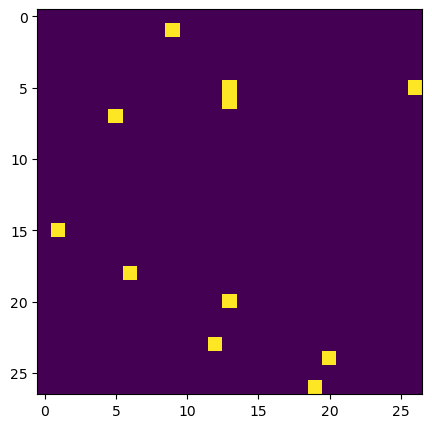

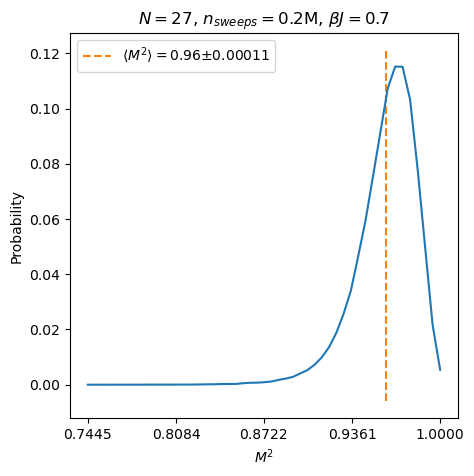

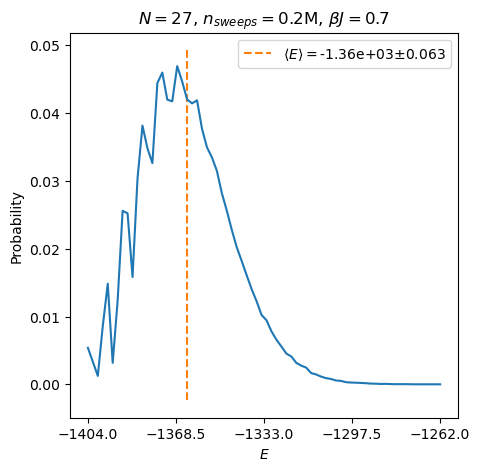

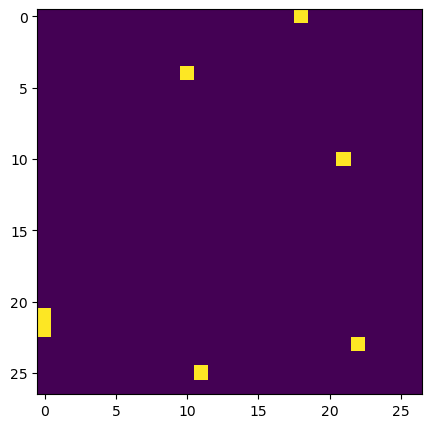

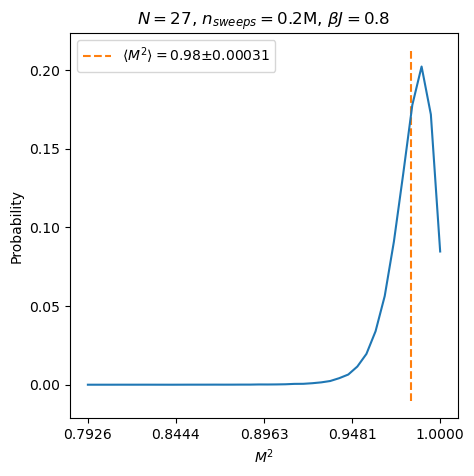

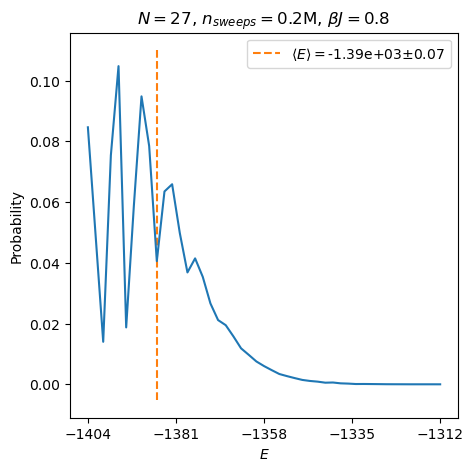

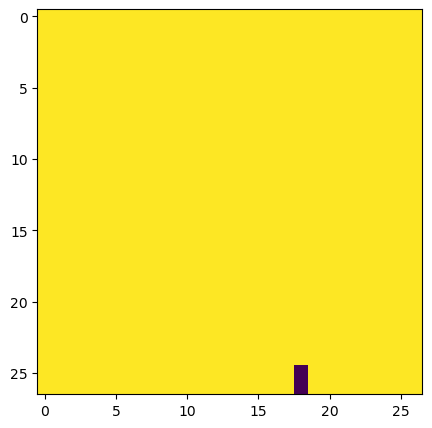

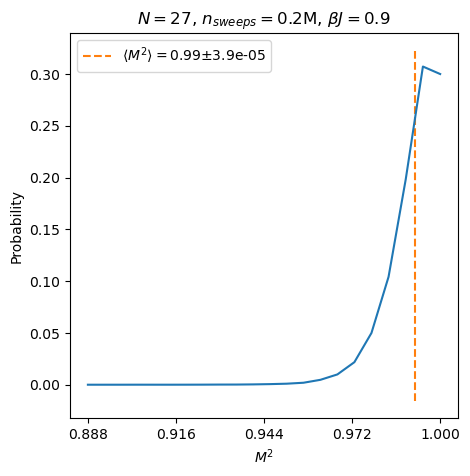

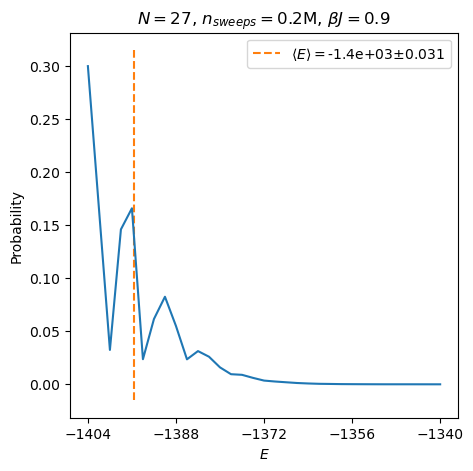

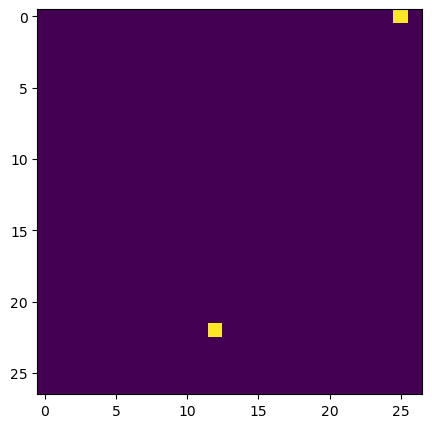

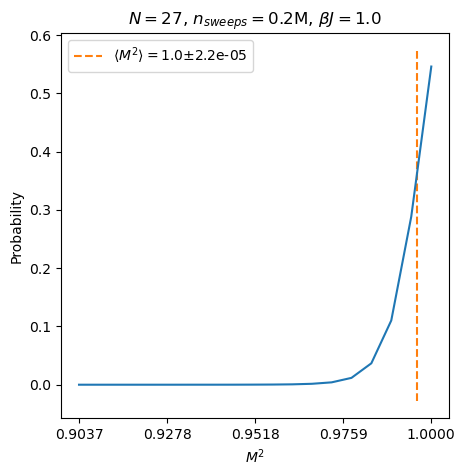

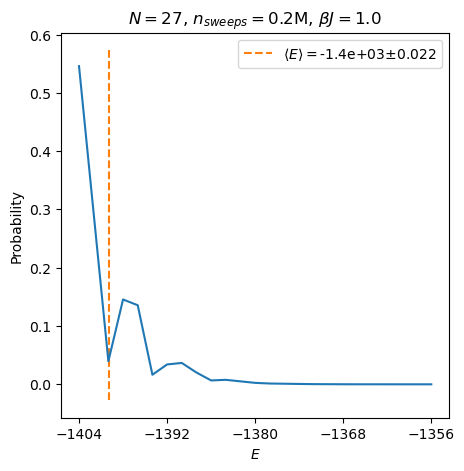

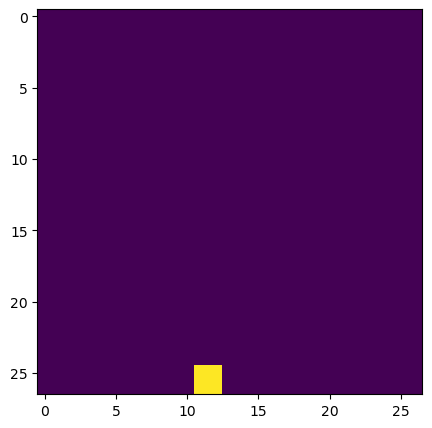

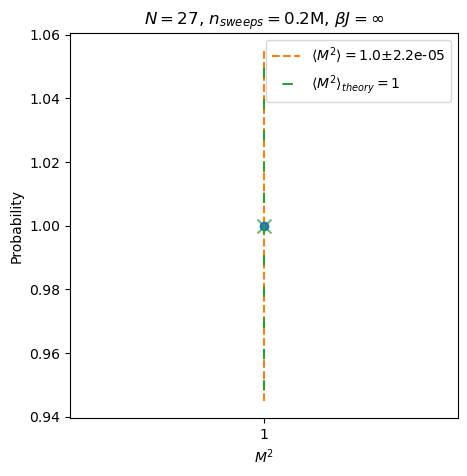

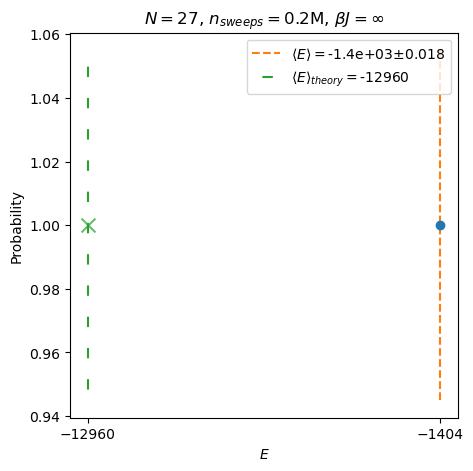

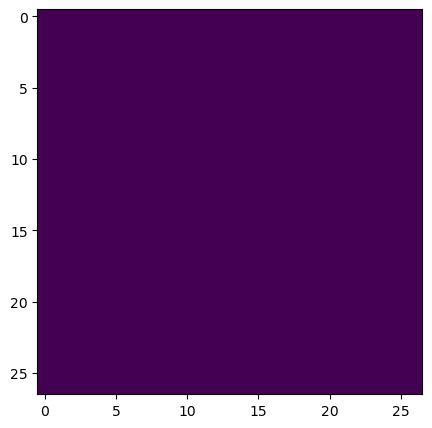

In [11]:
M0_theory = 0
Minf_theory = 1
E0_theory = 0
Einf_theory = -12960

for i in range(nbetas):
    beta = betas[i]

    ######### MAGNETIZATION #########

    fig, ax = plt.subplots(figsize=(5, 5))

    x = unique_mags[i].copy()
    argsort = np.argsort(x)
    x = x[argsort]
    y = prob_mags[i].copy()
    y = y[argsort]

    marker = ""
    if x.shape[0] > 1:

        xticks = np.linspace(x.min(), x.max(), 5)

    else:
        marker = "o"
        xticks = x

    ax.plot(x, y, marker, zorder=3)
    ylims = ax.get_ylim()

    ax.vlines(
        expected_mags[i],
        ylims[0],
        ylims[1],
        linestyle="dashed",
        color="tab:orange",
        label=r"$\langle M^{2} \rangle =$"
        + f"{expected_mags[i]:.2}"
        + r"$\pm$"
        + f"{error_mags[i]:.2}",
    )

    if i == 0:

        if M0_theory not in xticks:
            xticks = np.insert(xticks, 0, M0_theory)

        ax.vlines(
            M0_theory,
            ylims[0],
            ylims[1],
            linestyle=loose_dash,
            color="tab:green",
            label=r"$\langle M^{2} \rangle_{theory} =$" + f"{M0_theory}",
            zorder=10,
        )

        ax.scatter(M0_theory, 1, color="tab:green", marker="x", s=100, alpha=0.7)

    elif i == nbetas - 1:

        if Minf_theory not in xticks:
            xticks = np.append(xticks, Minf_theory)

        ax.vlines(
            Minf_theory,
            ylims[0],
            ylims[1],
            linestyle=loose_dash,
            color="tab:green",
            label=r"$\langle M^{2} \rangle_{theory} =$" + f"{Minf_theory}",
            zorder=10,
        )

        ax.scatter(Minf_theory, 1, color="tab:green", marker="x", s=100, alpha=0.7)

    xticks = np.round(xticks, 4)
    ax.set_xticks(xticks)
    ax.legend()

    ax.set_xlabel(r"$M^{2}$")
    ax.set_ylabel("Probability")

    title = (
        r"$N =$"
        + f"{N}, "
        + r"$n_{sweeps} = $"
        + f"{nsweeps / 1e6:2}M, "
        + r"$\beta J =$"
        + f"{beta_labels[i]:1}"
    )

    ax.set_title(title)

    ######### ENERGY #########

    fig, ax = plt.subplots(figsize=(5, 5))

    x = unique_energies[i].copy()
    argsort = np.argsort(x)
    x = x[argsort]
    y = prob_energies[i].copy()
    y = y[argsort]

    marker = ""
    if x.shape[0] > 1:

        xticks = np.linspace(x.min(), x.max(), 5)

    else:
        marker = "o"
        xticks = x

    ax.plot(x, y, marker, zorder=3)
    ylims = ax.get_ylim()

    ax.vlines(
        expected_energies[i],
        ylims[0],
        ylims[1],
        linestyle="dashed",
        color="tab:orange",
        label=r"$\langle E \rangle =$"
        + f"{expected_energies[i]:.3}"
        + r"$\pm$"
        + f"{error_energies[i]:.2}",
    )

    if i == 0:

        if E0_theory not in xticks:
            xticks = np.insert(xticks, 0, E0_theory)

        ax.vlines(
            E0_theory,
            ylims[0],
            ylims[1],
            linestyle=loose_dash,
            color="tab:green",
            label=r"$\langle E \rangle_{theory} =$" + f"{E0_theory}",
            zorder=10,
        )

        ax.scatter(E0_theory, 1, color="tab:green", marker="x", s=100, alpha=0.7)

    elif i == nbetas - 1:

        if Einf_theory not in xticks:
            xticks = np.append(xticks, Einf_theory)

        ax.vlines(
            Einf_theory,
            ylims[0],
            ylims[1],
            linestyle=loose_dash,
            color="tab:green",
            label=r"$\langle E \rangle_{theory} =$" + f"{Einf_theory}",
            zorder=10,
        )

        ax.scatter(Einf_theory, 1, color="tab:green", marker="x", s=100, alpha=0.7)

    xticks = np.round(xticks, 4)
    ax.set_xticks(xticks)
    ax.legend()

    ax.set_xlabel(r"$E$")
    ax.set_ylabel("Probability")

    title = (
        r"$N =$"
        + f"{N}, "
        + r"$n_{sweeps} = $"
        + f"{nsweeps / 1e6:2}M, "
        + r"$\beta J =$"
        + f"{beta_labels[i]:1}"
    )

    ax.set_title(title)

    fig, ax = plt.subplots(figsize=(5, 5))
    ax.imshow(lattices_beta[i][-1], vmin=-1, vmax=1)
    plt.show()

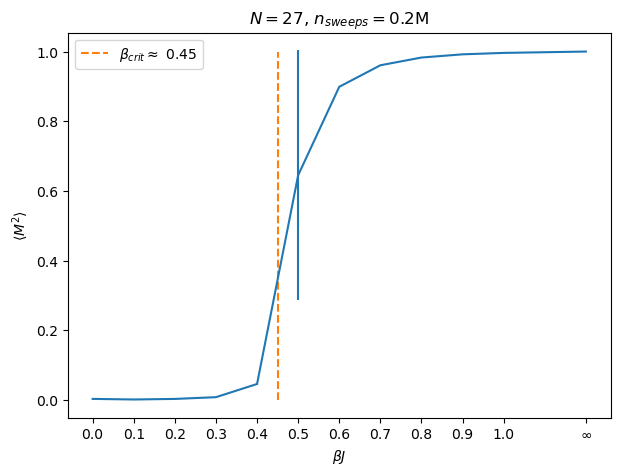

In [12]:
dMs = [expected_mags[i + 1] - expected_mags[i] for i in range(nbetas - 1)]
dMs = np.array(dMs)
argmax = dMs.argmax()
beta_approx = (betas[argmax] + betas[argmax + 1]) / 2
x = betas.copy()
x[-1] = 1.2

fig, ax = plt.subplots(figsize=(7, 5))
ax.vlines(
    beta_approx,
    0,
    1.0,
    color="tab:orange",
    linestyle="dashed",
    label=r"$\beta_{crit} \approx $ " + f"{beta_approx}",
)

ax.errorbar(x, expected_mags, yerr=error_mags)
ax.set_xticks(x, beta_labels)
ax.set_xlabel(r"$\beta J$")
ax.set_ylabel(r"$\langle M^{2} \rangle$")
ax.set_title(r"$N =$" + f"{N}, " + r"$n_{sweeps} = $" f"{nsweeps/1e6:2}M")

ax.legend()
plt.show()

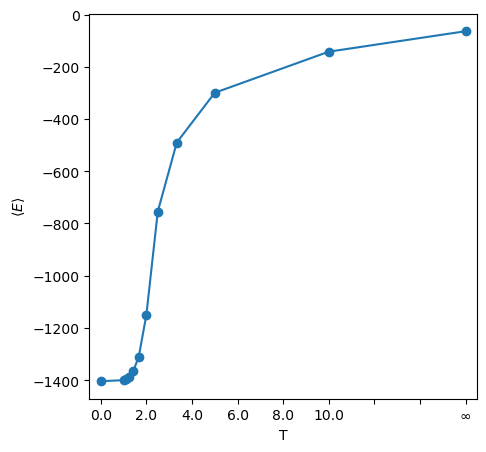

In [13]:
Ts = 1 / (betas[1:])
Ts = np.insert(Ts, 0, 16)
argsort = np.argsort(Ts)
Ts = Ts[argsort]
Es = expected_energies[argsort]

fig, ax = plt.subplots(figsize=(5, 5))

ax.plot(Ts, Es, marker="o")
ax.set_xlabel("T")
ax.set_ylabel(r"$\langle E \rangle$")

xticks = ax.get_xticks()
labels = xticks.astype(str)
labels[-2] = r"$\infty$"
labels[-3] = ""
labels[-4] = ""
ax.set_xticks(xticks, labels)
ax.set_xlim(-0.5, 16.5)
plt.show()

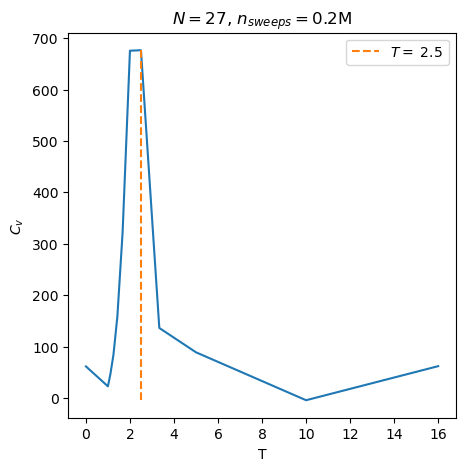

In [14]:
spline = scipy.interpolate.UnivariateSpline(Ts, expected_energies[argsort])
dEdT = spline.derivative()
y = dEdT(Ts)

fig, ax = plt.subplots(figsize=(5, 5))
ax.plot(Ts, y)
ax.set_xlabel("T")
ax.set_ylabel(r"$C_{v}$")
argmax = np.argmax(y)
ax.vlines(
    Ts[argmax],
    y.min(),
    y.max(),
    label=r"$T =$ " + f"{Ts[argmax]}",
    color="tab:orange",
    linestyle="dashed",
)

ax.legend()
ax.set_title(r"$N =$" + f"{N}, " + r"$n_{sweeps} = $" f"{nsweeps/1e6:2}M")
plt.show()

## Renormalization Group

In [15]:
@numba.njit(nogil=True, fastmath=True)
def coarse27(nbetas, nsweeps, lattices81):

    lattices81 = lattices81.copy()
    lattices27_coarse = np.zeros((nbetas, nsweeps + 1, 27, 27))
    mags27_coarse = np.zeros((nbetas, nsweeps + 1))

    for bi in range(nbetas):

        for sweep in range(nsweeps + 1):

            lattice81 = lattices81[bi, sweep, :, :]
            lattice27 = lattices27_coarse[bi, sweep, :, :]

            for i in range(27):

                for j in range(27):

                    sub_arr = lattice81[3 * i : 3 * (i + 1), 3 * j : 3 * (j + 1)]

                    if np.mean(sub_arr) < 0:

                        lattice27[i, j] = -1

                    else:

                        lattice27[i, j] = 1

            mags27_coarse[bi, sweep] = np.sum(lattice27)

    return lattices27_coarse, mags27_coarse


@numba.njit(nogil=True, fastmath=True)
def coarse9(nbetas, nsweeps, lattices27):

    lattices27 = lattices27.copy()
    lattices9_coarse = np.zeros((nbetas, nsweeps + 1, 9, 9))
    mags9_coarse = np.zeros((nbetas, nsweeps + 1))

    for bi in range(nbetas):

        for sweep in range(nsweeps + 1):

            lattice27 = lattices27[bi, sweep, :, :]
            lattice9 = lattices9_coarse[bi, sweep, :, :]

            for i in range(9):

                for j in range(9):

                    sub_arr = lattice27[3 * i : 3 * (i + 1), 3 * j : 3 * (j + 1)]

                    if np.mean(sub_arr) < 0:

                        lattice9[i, j] = -1

                    else:

                        lattice9[i, j] = 1

            mags9_coarse[bi, sweep] = np.sum(lattice9)

    return lattices9_coarse, mags9_coarse

In [16]:
try:
    lattices27_coarse = np.load("lattices27_coarse.npy")
    mags27_coarse = np.load("mags27_coarse.npy")

except:

    print("failed load")
    lattices27_coarse, mags27_coarse = coarse27(nbetas, nsweeps, lattices_beta)
    np.save("lattices27_coarse.npy", lattices27_coarse)
    np.save("mags27_coarse.npy", mags27_coarse)

failed load


ZeroDivisionError: division by zero

In [ ]:
N = 27
lattice27 = initLattice(N)
nsims = nbetas
lattices27_beta = np.empty((nsims, nsweeps + 1, N, N))
energies27_beta = np.empty((nsims, nsweeps + 1))
mags27_beta = np.empty((nsims, nsweeps + 1))

In [ ]:
try:
    lattices27_beta = np.load("lattices27_beta.npy")
    energies27_beta = np.load("energies27_beta.npy")
    mags27_beta = np.load("mags27_beta.npy")

except:
    print("failed load")
    for i in range(nbetas):
        lattices27_beta[i], energies27_beta[i], mags27_beta[i] = simulateMetropolis(
            lattice27, betas[i], nsweeps
        )

    np.save("lattices27_beta.npy", lattices_beta)
    np.save("energies27_beta.npy", energies_beta)
    np.save("mags27_beta.npy", mags_beta)

failed load


In [ ]:
expected_mags27_coarse = np.zeros_like(betas)
error_mags27_coarse = np.zeros_like(betas)
tcutoff_mags27_coarse = np.zeros_like(betas, dtype=object)
unique_mags27_coarse = np.zeros_like(betas, dtype=object)
prob_mags27_coarse = np.zeros_like(betas, dtype=object)

expected_mags27 = np.zeros_like(betas)
error_mags27 = np.zeros_like(betas)
tcutoff_mags27 = np.zeros_like(betas, dtype=object)
unique_mags27 = np.zeros_like(betas, dtype=object)
prob_mags27 = np.zeros_like(betas, dtype=object)

for i in range(nbetas):
    beta = betas[i]
    exp, err, tcut, unique, p = magExpectation(N, mags27_beta[i])
    expected_mags27[i] = np.round(exp, 12)
    error_mags27[i] = np.round(err, 12)
    tcutoff_mags27[i] = np.round(tcut, 12)
    unique_mags27[i] = np.round(unique, 12)
    prob_mags27[i] = np.round(p, 12)

    exp, err, tcut, unique, p = magExpectation(N, mags27_coarse[i])
    expected_mags27_coarse[i] = np.round(exp, 12)
    error_mags27_coarse[i] = np.round(err, 12)
    tcutoff_mags27_coarse[i] = np.round(tcut, 12)
    unique_mags27_coarse[i] = np.round(unique, 12)
    prob_mags27_coarse[i] = np.round(p, 12)

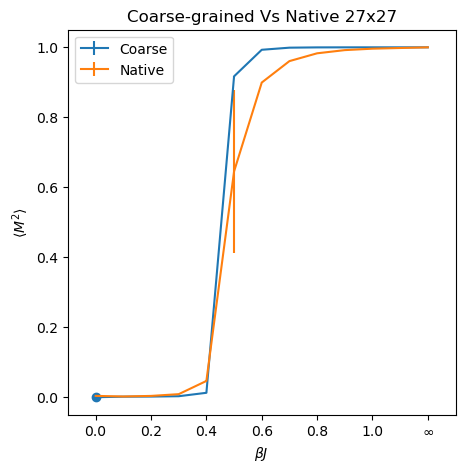

In [ ]:
fig, ax = plt.subplots(figsize=(5, 5))

x = betas.copy()
y = expected_mags27_coarse.copy()
x[-1] = 1.2
ax.errorbar(x, y, yerr=error_mags27_coarse, label="Coarse")
ax.set_xlabel(r"$\beta J$")
ax.set_ylabel(r"$\langle M^{2} \rangle$")
ax.set_title("Coarse-grained Vs Native 27x27")
xticks = np.round(axs[0].get_xticks(), 1)
labels = xticks.astype(str)
labels[-2] = beta_labels[-1]
ax.scatter(0, 0)
ax.set_xticks(xticks, labels)
ax.set_xlim(-0.1, 1.3)
y = expected_mags27.copy()
ax.errorbar(x, y, yerr=error_mags27, label="Native")
ax.legend()


plt.show()

## RJ

In [ ]:
subset = np.array([0, 1, 2, 3, 4, 5, 6, 7])
print(betas[subset])

expected_mags27_coarse_subset = expected_mags27_coarse[subset]

[0.  0.1 0.2 0.3 0.4 0.5 0.6 0.7]


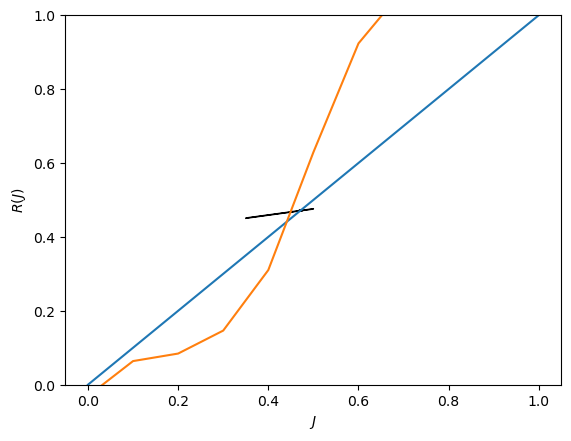

In [ ]:
R = scipy.interpolate.interp1d(
    expected_mags27[:-1], betas[:-1], fill_value="extrapolate"
)

plt.plot(betas[:-1], betas[:-1])
y = R(expected_mags27_coarse_subset)
plt.plot(betas[subset], R(expected_mags27_coarse_subset))
plt.ylim(0, 1)
cross = np.argmin(np.abs(betas[subset] - y))
plt.scatter(betas[cross], y[cross], marker="o", s=100)

j = 0.35
for i in range(5):
    rj = R(j)
    plt.arrow(j, rj, rj - j, R(rj) - rj)

    j = rj

j = 0.5
for i in range(5):
    rj = R(j)
    plt.arrow(j, rj, rj - j, R(rj) - rj)

    j = rj


# plt.arrow(0.35, R(0.35), 0, 0)
# plt.arrow(R(0.35), R(0.35), R(0.35), R(R(0.35))-.35)

plt.xlabel(r"$J$")
plt.ylabel(r"$R(J)$")

plt.show()

In [ ]:
Rspline = scipy.interpolate.UnivariateSpline(
    betas[subset], R(expected_mags27_coarse[subset])
)

v = Rspline.derivative()(0.5)
print(1 / (np.log(v) / np.log(3)))

1.264024785433487
